# exploratory data analysis<a id='3_Exploratory_Data_Analysis'></a>

## contents
* [introduction](#introduction)
* [imports and load](#imports_and_load)
* [exploration](#exploration_start)
    - [check for bias](#bias_check)
        - [bias in race](#race)
        - [type of diabetes](#type)
    - [demographic visualizations](#demo_viz)
    - [demographic readmit ratios](#demo_rat)
    - [admission source and type](#admit_st)
    - [admission measurements](#admit_metrics)

## introduction<a id='introduction'></a>

The goal of this analysis will be to understand this data more fully.  This exploration will inform modelling decisions and possibly reveal insights itself.  This work will include reviewing distributions, scaling, encoding and testing interactions.  Additional data may be merged during exploration as needed and available.

## imports and load<a id='imports_and_load'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import warnings 
import pandas_profiling
import feather

warnings.filterwarnings('ignore')
%matplotlib inline

C:\Users\ashby\AppData\Local\Temp\ipykernel_19532\1514250527.py:11: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


Pip requirements for reproducibility

In [2]:
pip list --format=freeze > requirements-nb2.txt

Note: you may need to restart the kernel to use updated packages.


Start with the output of the data wrangling and confirm load

In [3]:
admissions = feather.read_dataframe('../data/interim/notebook1_output.feather')
print(admissions.shape)
admissions.head(3)


(101727, 38)


,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide-metformin,change,diabetesMed,readmitted
encounter_id,,,,,,,,,,,,,,,,,,,,,
2278392,8222157,Caucasian,Female,[0-10),Other,Other,physicial referral,1,41,0,...,No,No,No,No,No,No,No,No,No,NO
149190,55629189,Caucasian,Female,[10-20),emergency,home,emergency room,3,59,0,...,No,No,No,No,No,Up,No,Ch,Yes,>30
64410,86047875,AfricanAmerican,Female,[20-30),emergency,home,emergency room,2,11,5,...,No,No,No,No,No,No,No,No,Yes,NO


In [4]:
admissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 101727 entries, 2278392 to 443867222
Data columns (total 38 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   patient_nbr               101727 non-null  int64   
 1   race                      101727 non-null  object  
 2   gender                    101727 non-null  object  
 3   age                       101727 non-null  category
 4   admission_type_id         101727 non-null  category
 5   discharge_disposition_id  101727 non-null  category
 6   admission_source_id       101727 non-null  category
 7   time_in_hospital          101727 non-null  int64   
 8   num_lab_procedures        101727 non-null  int64   
 9   num_procedures            101727 non-null  int64   
 10  num_medications           101727 non-null  int64   
 11  number_outpatient         101727 non-null  int64   
 12  number_emergency          101727 non-null  int64   
 13  number_inpatient    

## exploration<a id='exploration_start'></a>

### check for bias<a id='bias_check'></a>

#### race<a id='race'></a>

As there are demographics present, there is an opportunity to know if any particular group is over or under represented.  Race alone is the first target.  The 2000 [US Census](https://www2.census.gov/library/publications/decennial/2000/briefs/c2kbr01-01.pdf) reports a full population racial mix of 75.1% white and 12.3% black.

The American Diabetes Association [ADA](https://diabetes.org/about-us/statistics/about-diabetes#:~:text=Diabetes%20by%20race%2Fethnicity&text=12.1%25%20of%20non%2DHispanic%20blacks,7.4%25%20of%20non%2DHispanic%20whites) reports that 12.1% of  non-hispanic blacks and 7.4% of non-hispanic whites have diabetes diagnoses.  Ethnicity was not captured in this dataset so cannot be tested.




In [5]:
print('unique race values:', admissions.race.unique())
twoRace = admissions[admissions.race != 'Other'].copy()
twoRace_counts = twoRace.race.value_counts()
twoRace_fractions = twoRace.race.value_counts('normalize=True')

adj_white_count = twoRace_counts['Caucasian'] * 7.4
adj_black_count = twoRace_counts['AfricanAmerican'] * 12.1
adj_total = adj_white_count + adj_black_count
adj_white_perc = adj_white_count / adj_total
adj_black_perc = adj_black_count / adj_total
print('expected white fraction:', adj_white_perc)
print('observed white fraction:', twoRace_fractions['Caucasian'])
print('expected black fraction:', adj_black_perc)
print('observed black fraction:', twoRace_fractions['AfricanAmerican'])

unique race values: ['Caucasian' 'AfricanAmerican' 'Other']
expected white fraction: 0.7078017567818881
observed white fraction: 0.798421378564756
expected black fraction: 0.29219824321811194
observed black fraction: 0.201578621435244


To make this dataset unbiased, observations with a race value of "Caucasian" should make up ~71% of all observations.  The number of observations over that can be removed at random.

In [6]:
np.random.seed(42)
count_black = twoRace.race.value_counts()['AfricanAmerican']
count_white = twoRace.race.value_counts()['Caucasian']
white_to_remove = int(count_white - (count_black / 0.29 - count_black ))
raceWhite = twoRace[twoRace['race'] == 'Caucasian']
raceWhite = raceWhite.sample(raceWhite.shape[0] - white_to_remove)
raceBlack = twoRace[twoRace['race'] == 'AfricanAmerican']
twoRace = pd.concat( [raceBlack, raceWhite])
twoRace.race.value_counts('normalize=True')

Caucasian          0.710004
AfricanAmerican    0.289996
Name: race, dtype: float64

#### type of diabetes<a id='type'></a>

From here, statistics vary widely on prevalance of type 1 and type 2 diabetes by gender and age.  In general, males are more likely to have diabetes than females, but the gap between the sexes is smaller for type 1.  This dataset does contain the first 3 diagnoses for each admission.  Both ICD9 and ICD10 diagnoses codes are used.  ICD9 codes for diabetes start with 250 and ICD10 codes for type 1 start with E10 and type 2 start with E11.

In [7]:
twoRace[~(twoRace['diag_1'].str.contains('250')) &
        ~(twoRace['diag_1'].str.contains('E1')) &
        ~(twoRace['diag_2'].str.contains('250')) & 
        ~(twoRace['diag_2'].str.contains('E1')) &
        ~(twoRace['diag_3'].str.contains('250')) & 
        ~(twoRace['diag_3'].str.contains('E1')) 
       ].shape[0] / twoRace.shape[0] 

0.6218346545866364

Unfortunately, 62% of the observations here don't have any diabetes type diagnoses codes included.  Demographic bias corrections end here.

### demographic visualization <a id='demo_viz'></a>

<Figure size 640x480 with 0 Axes>

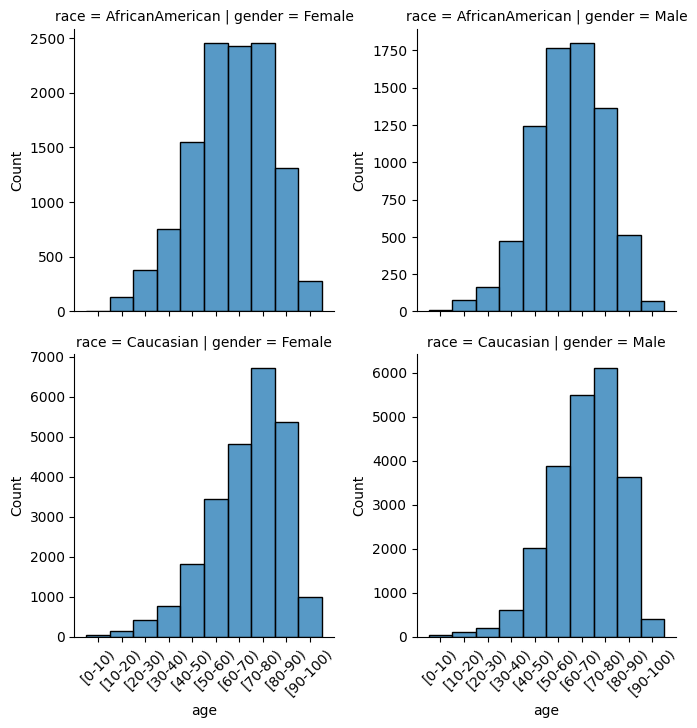

In [8]:
twoRace['age'] = pd.Categorical(twoRace['age'], ['[0-10)', '[10-20)', '[20-30)', '[30-40)', 
    '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)',])

plt.clf()

g = sns.FacetGrid(
    twoRace,
    col='gender',
    row='race',
    height=3.5,
    sharey=False
).map(sns.histplot, 'age')

for axes in g.axes.flat:
    for label in axes.get_xticklabels():
        label.set_rotation(45)

plt.show()

These distributions show that the various demographic combinations remaining in the dataset are well represented.  How are these combinations related to the readmission variable?  For this, I'll only be concerned with whether or not readmission happened and not whether or not in happened within 30 days.  I'll look at the readmit rate for each race, gender, age group combination.

<Figure size 640x480 with 0 Axes>

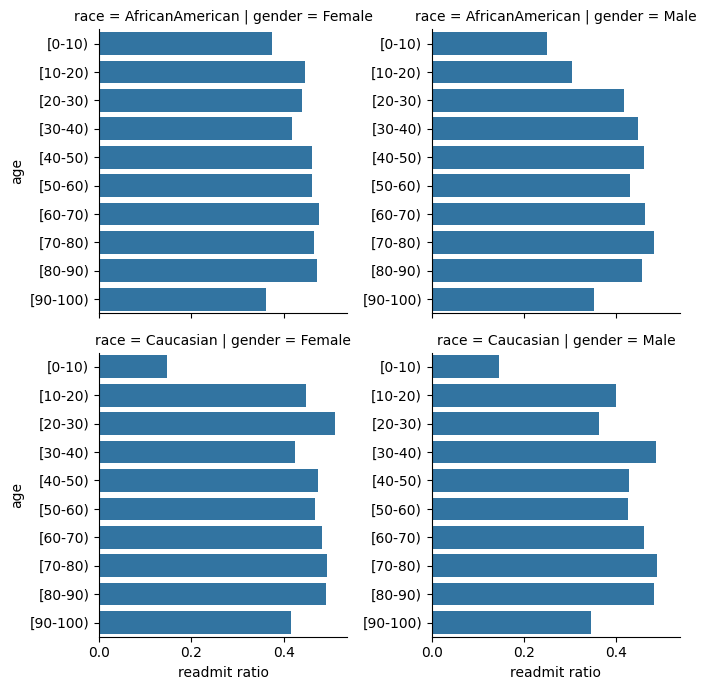

In [9]:
readmitMapping = {'NO': 0, '>30': 1, '<30': 1}
twoRace['readmitBinary'] = twoRace['readmitted'].replace(to_replace=readmitMapping)
demographic_readmit_mean = twoRace.groupby(['race','age','gender'])\
                           .agg([np.mean])['readmitBinary']\
                           .reset_index()

plt.clf()
g = sns.FacetGrid(
    demographic_readmit_mean,
    col='gender',
    row='race',
    height=3.5,
    sharey=False
).map(sns.barplot, 'mean', 'age')

[axes.set_xlabel('readmit ratio') for axes in g.axes.flat]

plt.show()

### demographic readmit ratios <a id='demo_rat'></a>

There are 2 notable items here.  
1. The 0-10 age group is very different between races
3. The 90-100 group has a lower ratio than most other age groups for each race/gender combination.

I suspect both of these can be explained with a small sample size

In [10]:
demographic_counts = twoRace.groupby(['age'])['patient_nbr'].count()
demographic_counts = demographic_counts.to_frame().reset_index()
demographic_counts[(demographic_counts['age'] == '[0-10)') | 
                   (demographic_counts['age'] == '[90-100)')]

,age,patient_nbr
0,[0-10),98
9,[90-100),1735


The small sample idea does hold for the 0-10 age group, but not the 90-100.  Its possible that the 90-100 age group expires during the admission more often than the others.  

In [11]:
twoRace['discharge_disposition_id'].unique()

['home', 'snf', 'Other', 'home health']
Categories (4, object): ['home', 'Other', 'snf', 'home health']

Expiration would fit into the 'Other' category, but so would transferred, etc.  Being discharged to a skilled nursing facility (SNF) or home health could also explain the lack of readmission as these would help with adherence to medical advice given at discharge.

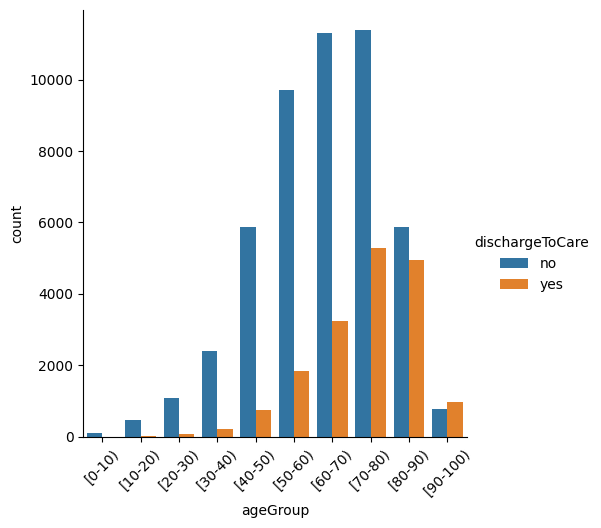

In [12]:
discharge_age_counts = twoRace.groupby(['age','discharge_disposition_id'])['patient_nbr'].count()
discharge_age_counts = discharge_age_counts.to_frame().reset_index()

discharge_age_counts.columns = ['ageGroup','dischargeToCare','count']
to_replace = {'Other': 'no', 'home': 'no', 'home health': 'yes', 'snf': 'yes'}
discharge_age_counts['dischargeToCare'] = discharge_age_counts['dischargeToCare'].replace(to_replace)
discharge_age_counts = discharge_age_counts.groupby(['ageGroup','dischargeToCare'])['count'].sum()
discharge_age_counts = discharge_age_counts.to_frame().reset_index()

_ = sns.catplot(data=discharge_age_counts
    , x='ageGroup' 
    , y='count' 
    , hue='dischargeToCare'
    , kind='bar'
)
plt.xticks(rotation=45)

plt.show()

The 90-100 age group is the only one where a patient is discharged to care more often than not.  The ratio of discharged to care vs not also increases with age after 30.  What does that look like?

<AxesSubplot: xlabel='ageGroup', ylabel='value'>

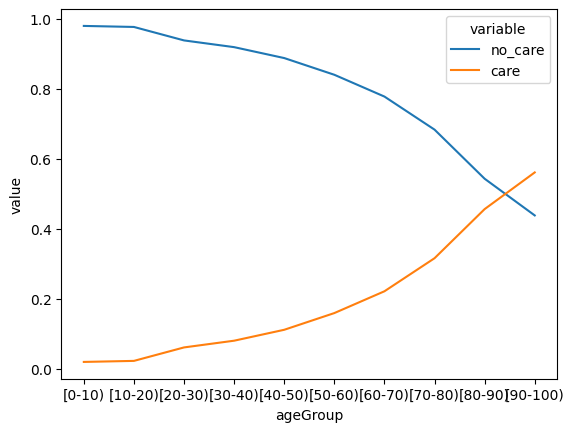

In [13]:
ratios = discharge_age_counts['count'] / \
         discharge_age_counts.groupby('ageGroup')['count'].transform('sum')
no_care = ratios[::2].to_frame().reset_index().drop(columns='index')
care = ratios[1::2].to_frame().reset_index().drop(columns='index')

age_ratios = pd.concat([no_care, care], axis=1)
age_ratios.columns=['no_care', 'care']
age_ratios['ageGroup'] = discharge_age_counts['ageGroup'].unique()

sns.lineplot(data=pd.melt(age_ratios, ['ageGroup']), x='ageGroup', y='value', hue='variable')


This is looking like a good candidate for a new feature.  Does it have a relationship to readmitted?

In [14]:
twoRace['DischargedToCare'] = twoRace['discharge_disposition_id'].replace(to_replace)

In [15]:
def chi2pvalue (rows, columns):
    contingency = pd.crosstab(rows, columns)
    _, p, _, _ = chi2_contingency(contingency)
    return p
    

In [16]:
chi2pvalue(twoRace.readmitted, twoRace.DischargedToCare)

9.39262946259018e-72

It does and this new feature will replace the discharge_disposition_id

In [17]:
twoRace = twoRace.drop(['discharge_disposition_id'], axis=1)

### admission source and type <a id='admit_st'></a>

These variables seem potentially redundant.  I will take a look at the frequency of combinations of their values.

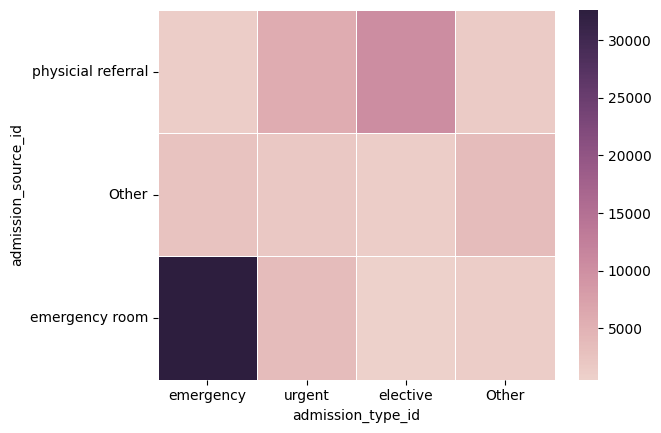

In [18]:
crosstab = pd.crosstab(twoRace['admission_source_id'], twoRace['admission_type_id'])
sns.heatmap(crosstab, cmap=sns.cubehelix_palette(as_cmap=True), yticklabels=True, linewidths=0.5)
plt.yticks(rotation=0)
plt.show()

The first item that stands out is that physical referral should be physician referral

In [19]:
twoRace['admission_source_id'] = twoRace['admission_source_id'].cat.rename_categories({'physicial referral': 'physician referral'})
twoRace.admission_source_id.unique()

['emergency room', 'Other', 'physician referral']
Categories (3, object): ['physician referral', 'Other', 'emergency room']

The next item that stands out is that these 2 look to have a strong association and are possibly redundant.  

In [20]:
chi2pvalue(twoRace.admission_source_id, twoRace.admission_type_id)

0.0

Because they are so closely related, I will compare simple logisitic regression models run with the readmitted binary variable and each of these variables independently as well as together to judge the value.  First, I need to encode them.

In [21]:
twoRace.admission_type_id = twoRace.admission_type_id.astype('category')
twoRace.admission_source_id = twoRace.admission_source_id.astype('category')

AdmissionFeatureSelection = twoRace[['admission_type_id','admission_source_id','readmitBinary']].copy()

encoder = OneHotEncoder(drop='first')
encoded = encoder.fit_transform(AdmissionFeatureSelection[['admission_type_id','admission_source_id']])

afs_encoded = pd.DataFrame(encoded.toarray(), columns=encoder.get_feature_names_out())
afs_encoded['readmitBinary'] = AdmissionFeatureSelection['readmitBinary'].values
afs_encoded

,admission_type_id_elective,admission_type_id_emergency,admission_type_id_urgent,admission_source_id_emergency room,admission_source_id_physician referral,readmitBinary
0,0.0,1.0,0.0,1.0,0.0,0
1,0.0,1.0,0.0,1.0,0.0,1
2,0.0,0.0,1.0,0.0,0.0,1
3,1.0,0.0,0.0,0.0,0.0,1
4,0.0,1.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...
66220,0.0,0.0,0.0,0.0,0.0,1
66221,0.0,1.0,0.0,1.0,0.0,0
66222,0.0,0.0,1.0,1.0,0.0,0
66223,0.0,0.0,1.0,0.0,1.0,0


Then create a function to do the regression and return a single metric. 

In [22]:
def simple_logreg (x, y):
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

    logreg = LogisticRegression()
    logreg.fit(x_train, y_train)
    y_pred = logreg.predict(x_test)

    label_and_weight = dict(zip(x.columns, logreg.coef_[0]))

    return accuracy_score(y_test, y_pred), label_and_weight

In [23]:
y = afs_encoded.readmitBinary

admission_type_x = afs_encoded.loc[:, afs_encoded.columns.str.contains('type')]
print(admission_type_x.shape)
simple_logreg(admission_type_x, y)

(66225, 3)


(0.5302289062028145,
 {'admission_type_id_elective': -0.34208973434550477,
  'admission_type_id_emergency': -0.07997740548052237,
  'admission_type_id_urgent': -0.11144173362381758})

In [24]:
admission_source_x = afs_encoded.loc[:, afs_encoded.columns.str.contains('source')]
print(admission_source_x.shape)
simple_logreg(admission_source_x, y)

(66225, 2)


(0.5302289062028145,
 {'admission_source_id_emergency room': 0.4017572686906928,
  'admission_source_id_physician referral': 0.16698493594568195})

In [25]:
both = afs_encoded.iloc[:, :-1]
simple_logreg(both, y)

(0.5377785830766443,
 {'admission_type_id_elective': -0.44556787850468665,
  'admission_type_id_emergency': -0.4441222259317295,
  'admission_type_id_urgent': -0.2737029830842031,
  'admission_source_id_emergency room': 0.5874350140854414,
  'admission_source_id_physician referral': 0.29237912536854177})

As the model using both the admission type and source is more accurate, both will be left in place.  It is also interesting that an emergency admission type means a patient is less likely to be readmitted than an emergency department source.  In hindsight, this is likely because trauma injuries would come through the emergency room and create an emergency admission with a low chance of readmission.

## admission measurements <a id="admit_metrics"></a>

The next set of interesting features to explore are the num* and time_in_hospital.  All of these metrics speak to the attributes of a patient's interactions with healthcare in the previous year.  Understanding the relationships between these variables as well as their relationship to readmission may yield additional insights into this dataset.  Number diagnoses will be included here as these are assigned during an encounter with a provider.  The details of these diagnoses will be left to the exploration of the diag_* variables.

In [26]:
print(twoRace.dtypes)
encounter_attributes = twoRace[['time_in_hospital',
                                'num_lab_procedures',
                                'num_medications',
                                'number_outpatient',
                                'number_emergency',
                                'number_inpatient',
                                'number_diagnoses']].copy()

patient_nbr               int64
race                     object
gender                   object
age                    category
admission_type_id      category
admission_source_id    category
time_in_hospital          int64
num_lab_procedures        int64
num_procedures            int64
num_medications           int64
number_outpatient         int64
number_emergency          int64
number_inpatient          int64
diag_1                   object
diag_2                   object
diag_3                   object
number_diagnoses          int64
max_glu_serum            object
A1Cresult                object
metformin                object
repaglinide              object
nateglinide              object
chlorpropamide           object
glimepiride              object
glipizide                object
glyburide                object
tolbutamide              object
pioglitazone             object
rosiglitazone            object
acarbose                 object
miglitol                 object
tolazami

In [27]:
profile = pandas_profiling.ProfileReport(encounter_attributes)
profile.to_widgets()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render widgets:   0%|          | 0/1 [00:00<?, ?it/s]

The first item that stands out in this profile is that many of the variables are a large percentage of zeroes.  For example, number_outpatient is ~84% zeroes.  These will be better represented as binary or categorical variables.  I will use the histograms in the profiling report to identify which variables should be transformed and what transformation would be most appropriate.  As a rule of thumb, variables where more than 75% of the values are 0 will be transformed into binary variables and variables with 50% or more zeroes will be binned into categorical variables.  

In [28]:
{col: (encounter_attributes[col] == 0).mean() * 100 for col in encounter_attributes}


{'time_in_hospital': 0.0,
 'num_lab_procedures': 0.0,
 'num_medications': 0.0,
 'number_outpatient': 83.7115892789732,
 'number_emergency': 88.36995092487732,
 'number_inpatient': 65.67761419403548,
 'number_diagnoses': 0.0}